# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

## 0. Data preparation

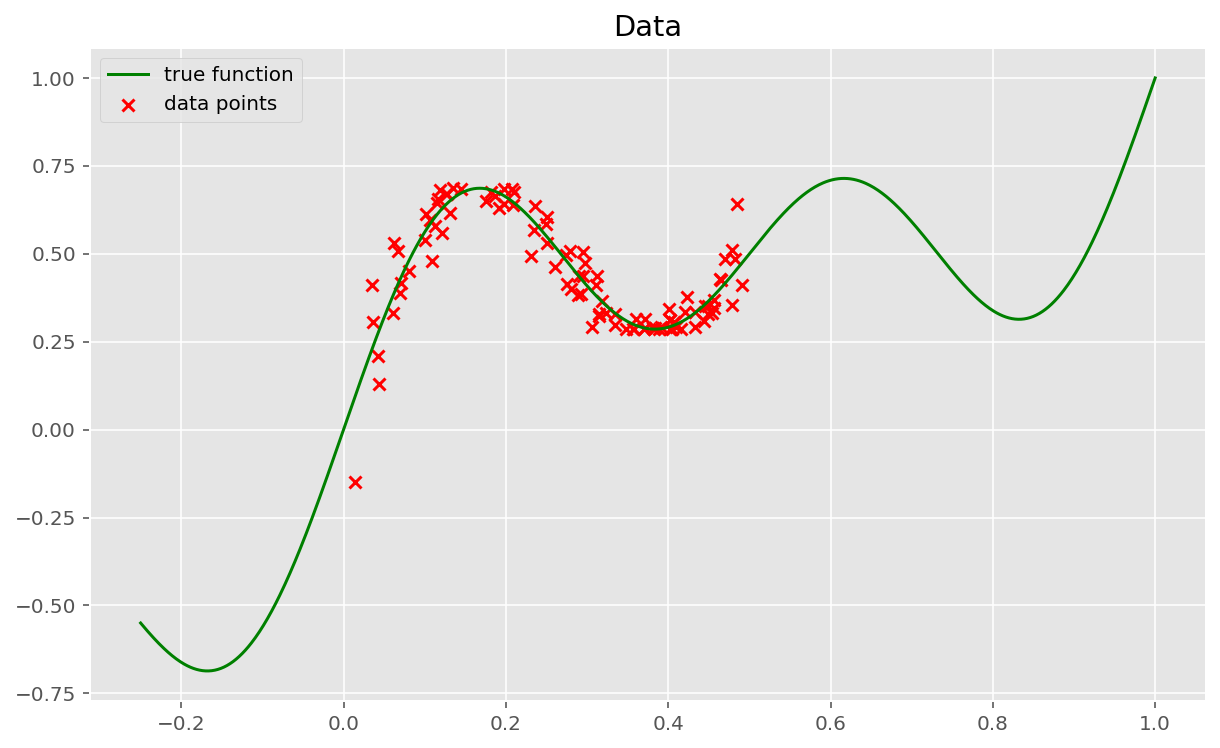

In [2]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x, epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0, 0.5, N)
dataset['y_train'] = function(dataset['X_train'], np.random.normal(0, sigma, N))

dataset['X_test'] = np.linspace(-0.25, 1, 1000)
F = function(dataset['X_test'], 0)

plt.figure(figsize=(10, 6))
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.scatter(dataset['X_train'], dataset['y_train'], marker='x', color='red', label='data points')
plt.legend()
plt.title("Data")
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [4]:
import models.deterministic_regression as dreg

##### Definition of the model

In [5]:
net = dreg.DeterministicNet(hidden_size=100, dim_input=1, dim_output=1)
reg_model = dreg.DeterministicReg(X_train_tensor, y_train_tensor, X_test_tensor, net)

##### Training step

In [6]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion, batch=False)

##### Test step

In [7]:
y_pred = reg_model.predict()

##### Plot results

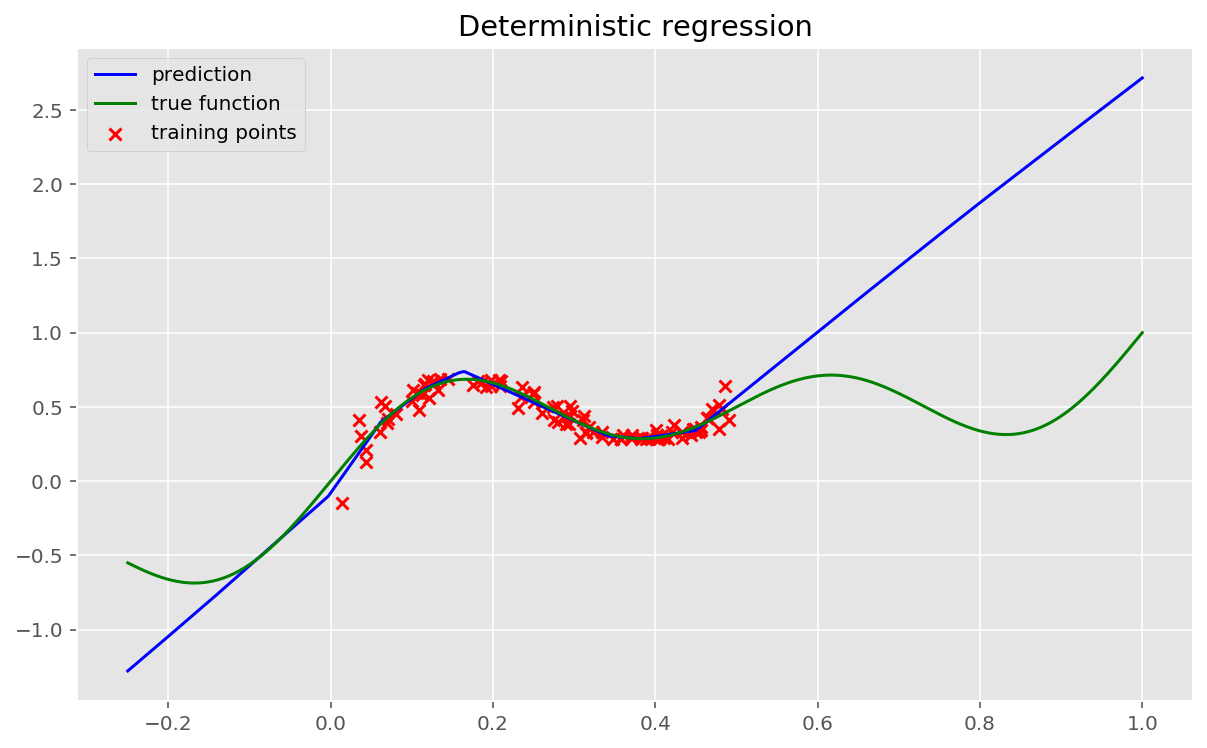

In [8]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

##### Plot weights distribution

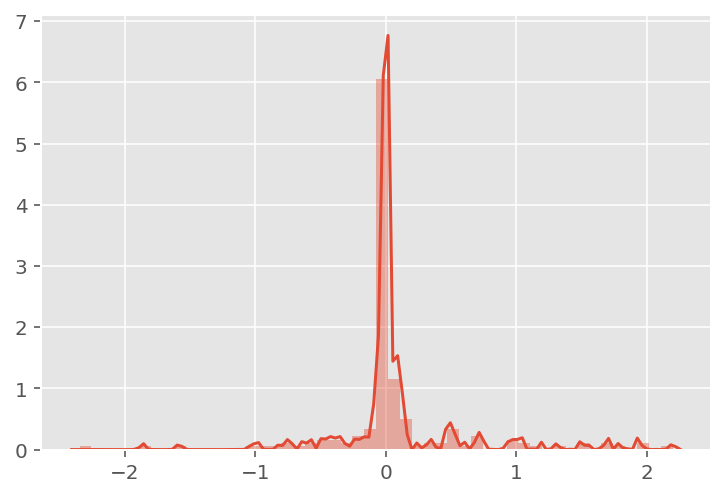

In [9]:
sns.distplot(net.weights_dist())

## 2. Bayesian regression with Monte-Carlo dropout

In [10]:
import models.dropout_regression as doreg

##### Definition of the model

In [11]:
net = doreg.DropoutNet(hidden_size=100, dim_input=1, dim_output=1, p=0.25)
reg_model = doreg.DropoutReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=X_train_tensor.shape[0])

##### Training step

In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion)

##### Test step

In [13]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

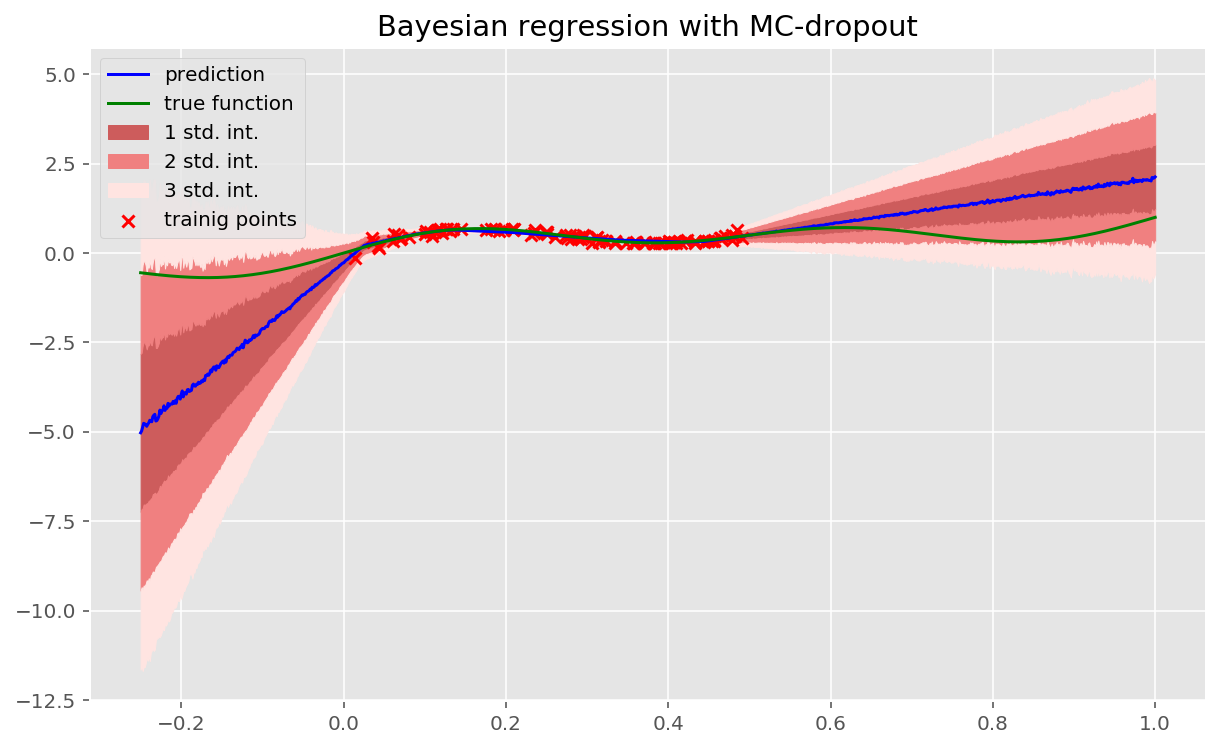

In [14]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title("Bayesian regression with MC-dropout")
plt.show()

##### Plot weights distribution

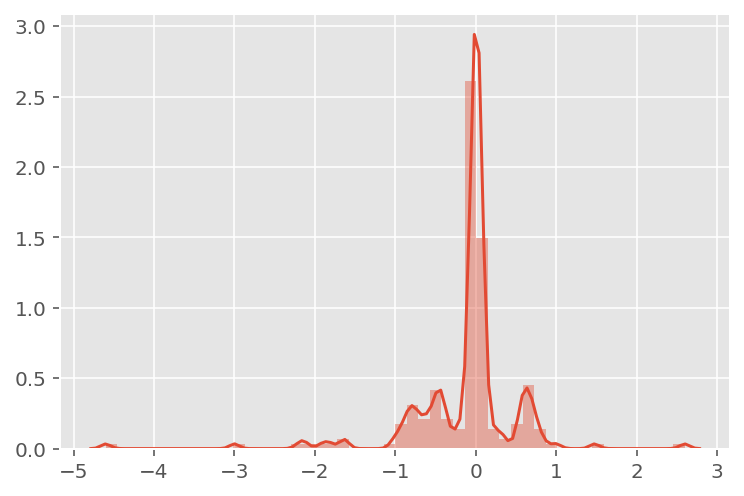

In [15]:
sns.distplot(net.weights_dist())
plt.show()

In [16]:
def log_likelihood(y, output, sigma=0.06):
    return torch.sum(-0.5 * np.log(2 * np.pi * sigma ** 2) 
                     - 0.5 * (y.squeeze() - output.squeeze()) ** 2 / sigma ** 2)

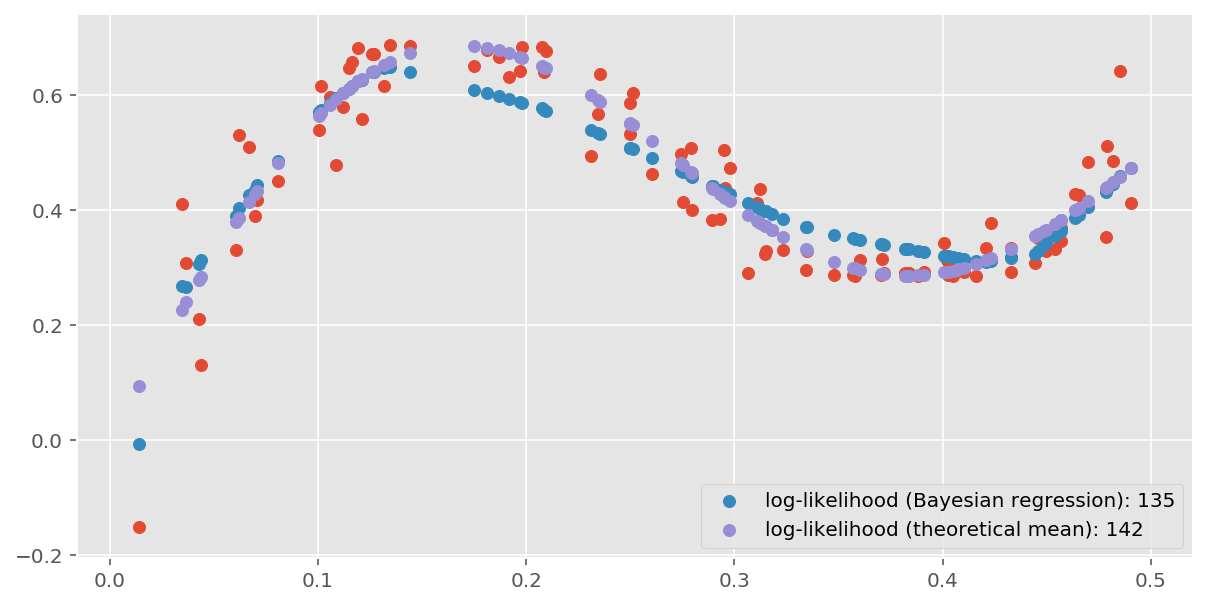

In [17]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(1000):
    y += net(reg_model.X_train) / 1000

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'log-likelihood (Bayesian regression): {log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'log-likelihood (theoretical mean): {log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()

## 3. Bayesian regression with Bayesian by Backpropagation

In [18]:
import models.bayesbackprop_regression as bbb

##### Definition of the model

In [19]:
prior_parameters = {'sigma1': 1, 'sigma2': np.exp(-6), 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size=64, dim_input=1, dim_output=1, prior_parameters=prior_parameters, sigma=0.06)
reg_model = bbb.BayesBackpropReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=10)

##### Training step

In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
reg_model.train(1000 , optimizer , 10 , weights = 'uniform')

Epoch:   50/1000, elbo loss = 101516.391, KL =  308.480, -log-likelihood = 101207.898
Epoch:  100/1000, elbo loss = 25918.383, KL =  319.624, -log-likelihood = 25598.756
Epoch:  150/1000, elbo loss = 10492.348, KL =  329.633, -log-likelihood = 10162.716
Epoch:  200/1000, elbo loss = 6185.030, KL =  336.420, -log-likelihood = 5848.610
Epoch:  250/1000, elbo loss = 3158.429, KL =  341.614, -log-likelihood = 2816.815
Epoch:  300/1000, elbo loss = 1663.099, KL =  344.946, -log-likelihood = 1318.153
Epoch:  350/1000, elbo loss = 1284.498, KL =  348.748, -log-likelihood = 935.750
Epoch:  400/1000, elbo loss = 1111.818, KL =  350.967, -log-likelihood = 760.851
Epoch:  450/1000, elbo loss = 1014.254, KL =  352.410, -log-likelihood = 661.844
Epoch:  500/1000, elbo loss =  646.432, KL =  355.591, -log-likelihood = 290.841
Epoch:  550/1000, elbo loss =  637.344, KL =  358.765, -log-likelihood = 278.579
Epoch:  600/1000, elbo loss =  565.342, KL =  358.859, -log-likelihood = 206.484
Epoch:  650/10

##### Test step

In [21]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

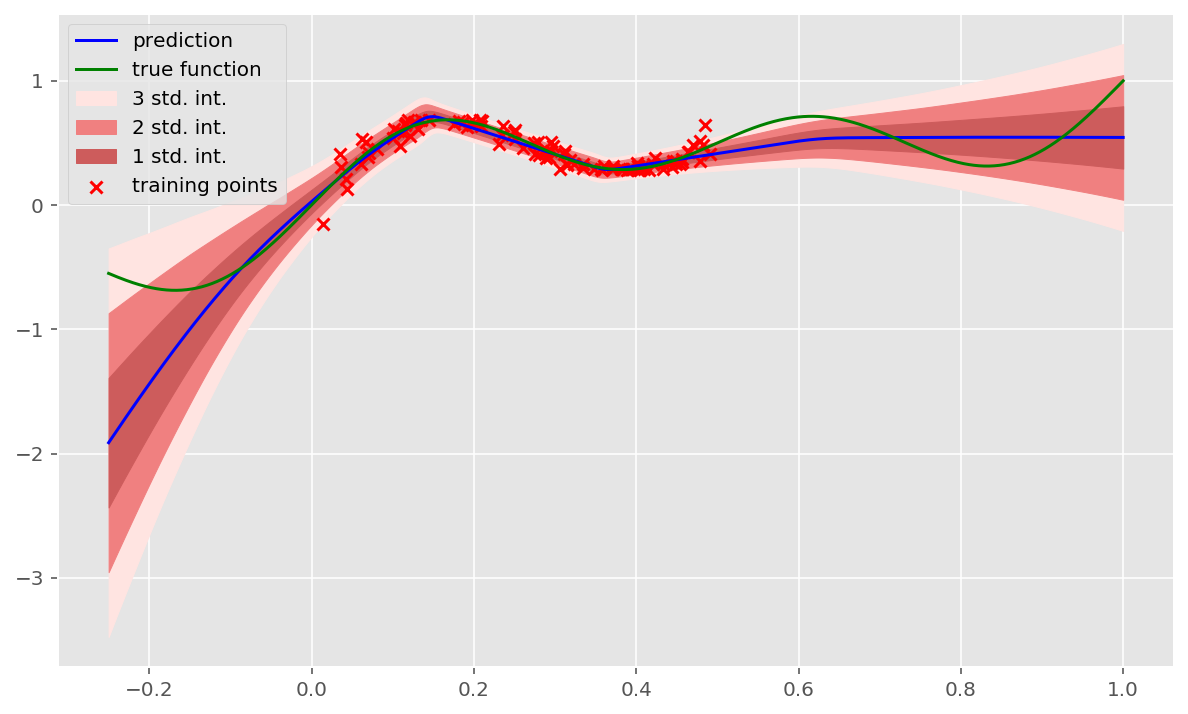

In [22]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.show()

##### Plot weights distribution

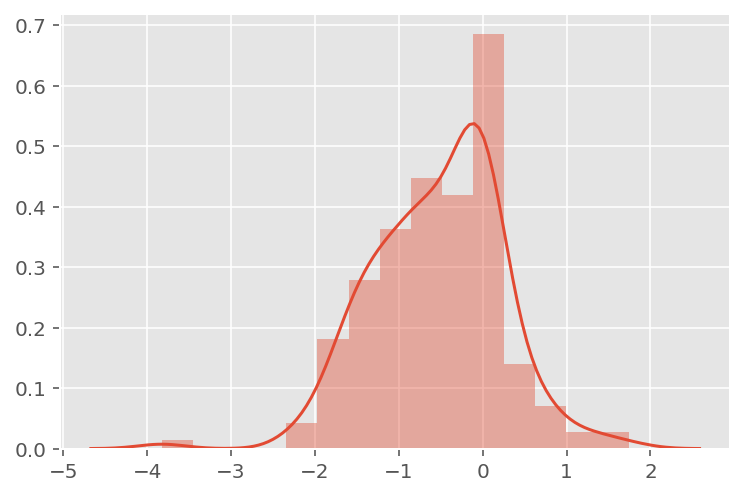

In [23]:
sns.distplot(net.weights_dist())
plt.show()

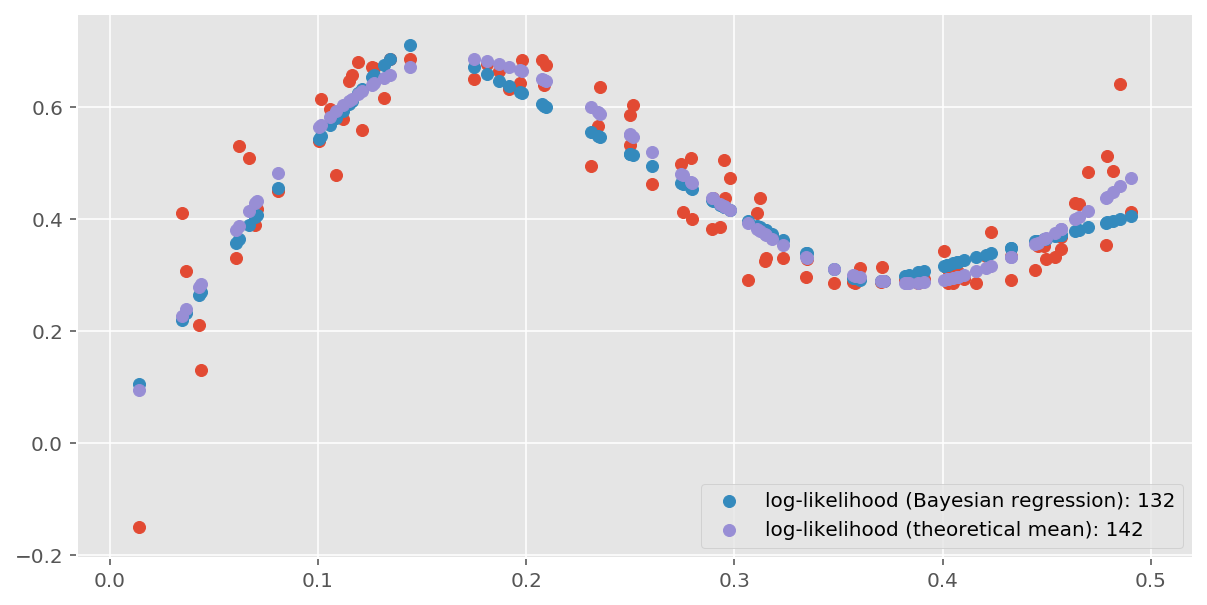

In [25]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(100):
    y += net(reg_model.X_train) / 100

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'log-likelihood (Bayesian regression): {log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0),  label=f'log-likelihood (theoretical mean): {log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()